In [1]:
%gui wx

%load_ext autoreload
%autoreload 2
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

In [3]:
current_dir = os.path.abspath("")
print(f"current_dir: {current_dir}")
sys.path.append(current_dir)

dataset_id = 'ds000171'
subjects = ['sub-control{:02d}'.format(i+1) for i in range(20)]

dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')

subject = "sub-control01"

mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)

current_dir: /data


In [4]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

21:54:59: Debug: Adding duplicate image handler for 'Windows bitmap file'
21:54:59: Debug: Adding duplicate animation handler for '1' type
21:54:59: Debug: Adding duplicate animation handler for '2' type
21:54:59: Debug: Adding duplicate image handler for 'Windows bitmap file'
21:54:59: Debug: Adding duplicate animation handler for '1' type
21:54:59: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:10106): Gtk-CRITICAL **: 21:54:59.429: gtk_window_resize: assertion 'height > 0' failed


Overview of the brain before any preprocessing

In [4]:
fsleyesDisplay.resetOverlays()
image_path = op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject)
fsleyesDisplay.load(image_path)


(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:02.925: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:02.927: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:02.928: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:02: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:02.930: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:02: Debug: ClientToScreen cannot work when toplevel wi

1. Skull Removal

In [5]:
from preprocessed import get_skull_stripped_anatomical

resulting_mask = get_skull_stripped_anatomical(dataset_path, preproc_path, subject, robust=True)

Done with BET.


In [6]:
fsleyesDisplay.resetOverlays()

fsleyesDisplay.load(op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject))
fsleyesDisplay.load(resulting_mask)


(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:13.111: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:13.113: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:13.114: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:13: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:13.116: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:13: Debug: ClientToScreen cannot work when toplevel wi

In [7]:
# The brain without skull is in the derivatives folder
from preprocessed import apply_fsl_mask

betted_brain_path = apply_fsl_mask(dataset_path, resulting_mask, preproc_path, subject)

In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)


(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:15.563: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:15.565: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:15.566: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown
21:45:15: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:45:15.567: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:45:15: Debug: ClientToScreen cannot work when toplevel wi

In [9]:
#TODO discuss segmentation

In [10]:
from preprocessed import apply_fast
bet_path = apply_fast(preproc_path, subject)

In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_path, subject, 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'


(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:48:06.757: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:48:06.760: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:48:06.763: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown
21:48:06: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8846): Gdk-WARNING **: 21:48:06.766: gdkdrawable-x11.c:952 drawable is not a pixmap or window
21:48:06: Debug: ClientToScreen cannot work when toplevel wi

## Linear normalization using Ants
Using advanced normalization tools (ANTS), we standardize the fMRI to a standard, to be able to do comparaisons.

In [12]:
type_of_transform = 'SyN'
subfolder='anat'
target = op.join(preproc_path, '{}'.format(subject), 'anat', '{}_T1w'.format(subject))
reference = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')

    # Compute the transformation (non linear) to put align the moving image to the fixed image
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = type_of_transform)

    # After the transformation has been computed, apply it
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])

    # Save the image to disk
resultAnts = op.join(preproc_path, subject, subfolder, '{}_T1w_mni_{}.nii.gz'.format(subject, type_of_transform))
ants.image_write(warpedImage, resultAnts)

In [23]:
%autoreload 3

In [5]:
from preprocessed import apply_ants
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
resultAnts = apply_ants(preproc_path, subject, mni_template)

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
fsleyesDisplay.load(resultAnts)


(ipykernel_launcher.py:10106): Gdk-WARNING **: 21:57:13.525: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## Field Stabilisation
Field Stabilisation doesn't seem necessary

Text(0, 0.5, 'Mean voxel intensity')

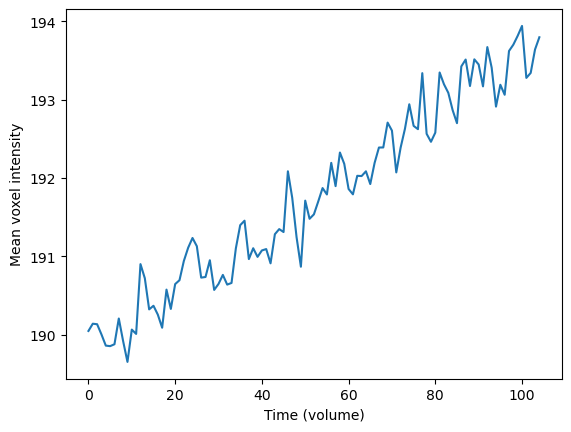

In [13]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load("/data/data/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz").get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

## Motion correction

In [27]:
from preprocessed import apply_mcflirt
task = 'music'
run = '1'
path_moco_data = apply_mcflirt(dataset_path, preproc_path, subject, task, run)
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

Processed data will be saved as /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


In [ ]:
print("T")